In [1]:
import sys
from pathlib import Path

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))

# Initialise SPS 
from indirect_identification.sps_indirect import SPS_indirect_model


Current Directory: C:\Users\Jake\Learning-Dynamic-Systems\search\notebooks
Parent Directory: C:\Users\Jake\Learning-Dynamic-Systems


In [2]:
pip install redis[hiredis]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Initialise ARMAX Models and Generate Data

In [3]:
from indirect_identification.armax import ARMAX
from indirect_identification.d_tfs import d_tfs
import numpy as np
from scipy import signal, optimize
from search.test_systems import OpenLoop1, OpenLoop2, ClosedLoop1, ClosedLoop2, a1_true, a2_true, b1_true, b2_true

ol_1 = OpenLoop1
ol_2 = OpenLoop2
cl_1 = ClosedLoop1
cl_2 = ClosedLoop2

n_samples = 1000


## Least Squares callback

In [4]:
from indirect_identification.d_tfs import d_tfs
import numpy as np

is_verbose = False
# Least squares function
def test_ls(params, U, Y, armax_model, n_a, n_b):
    """
        params: vector of parameters to test
        K:      gain of the controller for this test run. Currently assumed to be constant
        U: U_t signal
        Y: Y_t signal
    """
    if is_verbose:
        print(f"Calculating loss with params {params}")
        [print(f"Number of inputs: {len(U)}")]
        [print(f"Number of outputs: {len(Y)}")]

    params = list(params)
    a = []
    b = []
    for _ in range(n_a):
        a.append(params.pop(0))

    for _ in range(n_b):
        b.append(params.pop(0))


    A = [1, *a]
    B = [0, *b]
    C = [1]

    G = d_tfs((B, A))
    H = d_tfs((C,A))


    L = d_tfs((armax_model.L, [1]))
    F = d_tfs((armax_model.F, [1]))

    model = SPS_indirect_model(1,1) # Dummy model for open_loop

    G_0, H_0 = G, H
    if F != [0] and F != 0:
        G_0, H_0 = model.transform_to_open_loop(G, H, F, L, supress_stability=True)

    YGU = Y - G_0 * U
    N_hat = (1/H_0) * YGU

    ret_val = np.sum([N_hat**2])  # Return SSE
    if is_verbose:
        print(ret_val)
    return ret_val

## Calculate the LSE

In [5]:
def get_lse(U, Y, armax_model, n_a, n_b):
    x0 = np.zeros( (n_a + n_b)) #  + np.random.randn(n_a + n_b)
    res = optimize.least_squares(test_ls, x0, args=(U, Y, armax_model, n_a, n_b))

    params_ls = res.x
    return params_ls

## Initialise the SPS Model and Search Callback

In [6]:
m = 100
q = 5

model = SPS_indirect_model(m, q, N=100)

def sps_test_function(params, F, L, U, Y, n_a, n_b):
    if is_verbose:
        print("Testing", params)

    params = list(params)

    a = []
    b = []
    for _ in range(n_a):
        a.append(params.pop(0))

    for _ in range(n_b):
        b.append(params.pop(0))
        
    A = [1, *a]
    B = [0, *b]
    C = [1]

    G = d_tfs((B, A))  # G should be a tuple of arrays
    H = d_tfs((C, A))  # H should be a tuple of arrays

    L = d_tfs((L, [1]))
    F = d_tfs((F, [1]))

    G_0, H_0 = G, H
    try:
        if F != [0] and F != 0:
            G_0, H_0 = model.transform_to_open_loop(G, H, F, L, supress_stability=False)
    
        in_sps, S1 = model.open_loop_sps(G_0=G_0, H_0=H_0, Y_t=Y, U_t=U, n_a=n_a, n_b=n_b)
    except ValueError as e:
        return False

    # Check the condition and store the result if true
    return in_sps



### Generate Unit Vectors

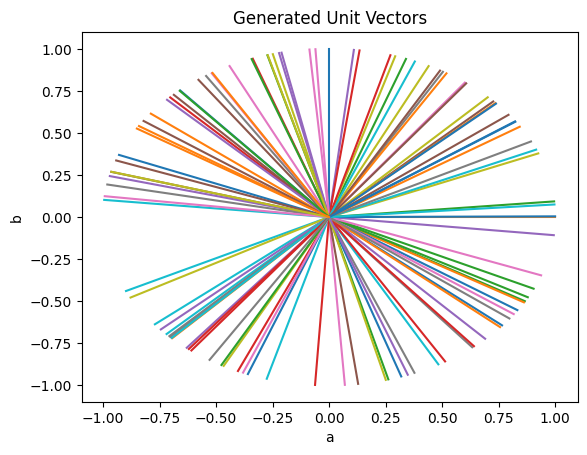

In [7]:
n_dim = 2
n_random_vectors = 100
vectors = []

# Generate Basis Vectors

v1 = np.array([0,1])
v2 = np.array([1,0])

vectors.extend([v1, v2])

for _ in range(n_random_vectors):
    rand_vec = np.random.uniform(-1, 1) * v1 + np.random.uniform(-1, 1) * v2 # Create random linear combination of basis vectors
    rand_vec /= np.linalg.norm(rand_vec)    # Normalise to create unit vector
    vectors.extend(np.array([rand_vec]))

vectors = np.array(vectors)

# Plot the vectors
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_title("Generated Unit Vectors")
ax.set_xlabel("a")
ax.set_ylabel("b")

for i in range(len(vectors)):
    ax.plot([0, vectors[i, 0]], [0, vectors[i, 1]])



In [8]:

def get_unit_vectors(n_dim, n_vectors):
    basis_vectors = np.eye(n_dim)
    vectors = basis_vectors

    for _ in range(n_vectors):
        rand = np.random.uniform(-1, 1, n_dim)
        rand /= np.linalg.norm(rand)    # Normalise to create unit vector
        
        vectors = np.append(vectors, rand)

    return vectors.reshape((n_vectors + n_dim, n_dim))


In [9]:
def expand_convex_hull(hull_points, expansion_factor=0.05):
    """Expand the convex hull by a small factor to make it slightly larger."""
    hull_center = np.mean(hull_points, axis=0)
    expanded_points = []
    
    for point in hull_points:
        direction = point - hull_center
        expanded_point = point + direction * expansion_factor
        expanded_points.append(expanded_point)
    
    return np.array(expanded_points)

In [10]:
from scipy.spatial import ConvexHull

MAX_RADIUS = 1

# TODO: Add max values?
# - Max increase per iteration
def test_one_direction(unit_vector, lse, F, L, U, Y, n_a, n_b, starting_radius=0.1, epsilon=0.01, max_iterations=100):
    # scale the vector
    radius = starting_radius

    attempt_no = 0

    highest_true = None
    lowest_false = None

    current_error = 1

    ins = []
    outs = []
    boundary = None

    while current_error > epsilon and attempt_no < max_iterations and radius < MAX_RADIUS:
        attempt_no += 1

        # Convert coordinates to cartesian
        coords = radius * unit_vector + lse

        in_sps = sps_test_function( tuple(coords), F, L, U, Y, n_a, n_b)

        # Update search params
        if in_sps:
            ins.append(np.array(coords))
            highest_true = radius

            if lowest_false:
                radius = highest_true + (lowest_false - highest_true) / 2
            else:
                radius *= 2

        else:
            outs.append(np.array(coords))
            lowest_false = radius

            if highest_true:
                radius = highest_true + (lowest_false - highest_true) / 2
            else:
                radius /= 2

        if highest_true and lowest_false:
            current_error = lowest_false - highest_true

    # TODO: Calculate n-dimensional boundary point
    boundary = None
    return (ins, outs, boundary)

def epoch(vectors, params_ls, F, L, U, Y, n_a, n_b):
    # Plot data
    ins = []
    outs = []
    boundaries = []

    # Sort the vectors according to angle
    vectors = sorted(vectors, key=lambda x: (np.atan2(x[1], x[0])))


    for vector in vectors:
        new_ins, new_outs, boundary= test_one_direction(vector, params_ls, F, L, U, Y, n_a, n_b)
        ins.extend(new_ins)
        outs.extend(new_outs)
        boundaries.append(boundary)


    ins = np.array(ins)
    outs = np.array(outs)
    boundaries.append(boundaries[0])
    boundaries = np.array(boundaries)

    hull = []
    expanded_hull = []

    try:
        hull = ConvexHull(ins)
        expanded_hull = expand_convex_hull(ins[hull.vertices], expansion_factor=0.01)
        expanded_hull = np.vstack(expanded_hull, expanded_hull[0])
    except:
        pass
    
    return (ins, outs, boundaries, hull, expanded_hull)




In [ ]:
# Plot the results
def plot_2d_results(params_ls, ins, outs, boundaries, hull, expanded_hull):
    a0 = params_ls[0]
    b0 = params_ls[1]

    fig, ax = plt.subplots()
    ax.plot(a0, b0, 'o', label="Least Squares Estimate")
    ax.plot(a1_true, b1_true, '*', c='orange', label="True Parameter", )

    if len(ins) > 0:
        ax.scatter(ins[:, 0], ins[:, 1], marker='.', c='red', label="tested in SPS")
    if len(outs) > 0:
        ax.scatter(outs[:, 0], outs[:, 1], marker='.', c='blue', label="tested not in SPS")
    # if len(boundaries) > 0:
    #     ax.plot(boundaries[:, 0], boundaries[:, 1], marker='.', c='green', label="linear boundary")
    if len(boundaries) > 0:
        ax.plot(expanded_hull[:, 0], expanded_hull[:, 1], marker='.', c='orange', label="convex hull (expanded)")
    ax.legend()

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel("a")
    ax.set_ylabel("b")
    ax.set_title("Radial search output")

Average SPS calls per angle: 5.36


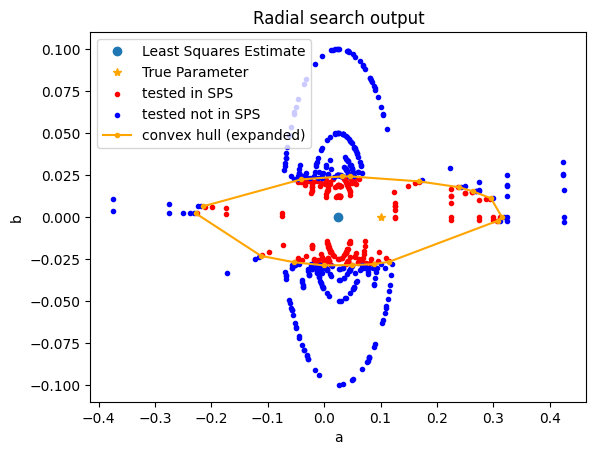

In [19]:
# Test one model

def test_model(armax_model, n_vectors):
    n_a = len(armax_model.A) - 1
    n_b = len(armax_model.B)
    vectors = get_unit_vectors(n_a + n_b, n_vectors)
    # Initialise the system
    R = signal.square(np.linspace(0, 10*np.pi, n_samples))
    Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.1)

    # Calculate the LSE
    params_ls = get_lse(U, Y, armax_model, n_a, n_b )

    return params_ls, *epoch(vectors, params_ls, armax_model.F, armax_model.L, U, Y, n_a, n_b)

params_ls, ins, outs, boundaries, hull, expanded_hull = test_model(ol_1, n_vectors=n_random_vectors)
print("Average SPS calls per angle: %.2f" % ((len(ins) + len(outs)) / n_random_vectors))
plot_2d_results(params_ls, ins, outs, boundaries, hull, expanded_hull)

In [13]:
# Simple Benchmark
import time

test_models = [ol_1, ol_2, cl_1, cl_2]
test_n_vectors = [10, 25, 50, 100, 250, 500, 1000]
num_iters = 50

curr_results = []
models_dict = {}


for model_under_test in test_models:
    results_dict = {}

    for n_vectors in test_n_vectors:
        for _ in range(num_iters):
            print(model_under_test, ":", n_vectors, "-", _)
            start_time = time.time()
            params_ls, ins, outs, boundaries, hull, expanded_hull = test_model(model_under_test, n_vectors = n_vectors)
            end_time = time.time()
            
            curr_results.append(end_time - start_time)

        results_dict[n_vectors] = np.array(curr_results)
    models_dict[model_under_test] = results_dict
    



<indirect_identification.armax.ARMAX object at 0x000001B8EB0CD010> : 10 - 0
<indirect_identification.armax.ARMAX object at 0x000001B8EB0CD010> : 10 - 1
<indirect_identification.armax.ARMAX object at 0x000001B8EB0CD010> : 10 - 2
<indirect_identification.armax.ARMAX object at 0x000001B8EB0CD010> : 10 - 3
<indirect_identification.armax.ARMAX object at 0x000001B8EB0CD010> : 10 - 4
<indirect_identification.armax.ARMAX object at 0x000001B8EB0CD010> : 10 - 5
<indirect_identification.armax.ARMAX object at 0x000001B8EB0CD010> : 10 - 6
<indirect_identification.armax.ARMAX object at 0x000001B8EB0CD010> : 10 - 7
<indirect_identification.armax.ARMAX object at 0x000001B8EB0CD010> : 10 - 8
<indirect_identification.armax.ARMAX object at 0x000001B8EB0CD010> : 10 - 9
<indirect_identification.armax.ARMAX object at 0x000001B8EB0CD010> : 10 - 10
<indirect_identification.armax.ARMAX object at 0x000001B8EB0CD010> : 10 - 11
<indirect_identification.armax.ARMAX object at 0x000001B8EB0CD010> : 10 - 12
<indirect

KeyboardInterrupt: 

In [ ]:
print(results_dict)

 
for model_under_test in test_models:
    for x in test_n_vectors:
        mean = np.mean(models_dict[model_under_test][x])
        print(mean)

{10: array([0.07011151, 0.08945107, 0.14057732, 0.20846677, 0.52505445,
       0.84378719, 1.63018298, 0.25398231]), 25: array([0.07011151, 0.08945107, 0.14057732, 0.20846677, 0.52505445,
       0.84378719, 1.63018298, 0.25398231, 0.27832103]), 50: array([0.07011151, 0.08945107, 0.14057732, 0.20846677, 0.52505445,
       0.84378719, 1.63018298, 0.25398231, 0.27832103, 0.33448362]), 100: array([0.07011151, 0.08945107, 0.14057732, 0.20846677, 0.52505445,
       0.84378719, 1.63018298, 0.25398231, 0.27832103, 0.33448362,
       0.43543124]), 250: array([0.07011151, 0.08945107, 0.14057732, 0.20846677, 0.52505445,
       0.84378719, 1.63018298, 0.25398231, 0.27832103, 0.33448362,
       0.43543124, 0.72030878]), 500: array([0.07011151, 0.08945107, 0.14057732, 0.20846677, 0.52505445,
       0.84378719, 1.63018298, 0.25398231, 0.27832103, 0.33448362,
       0.43543124, 0.72030878, 1.32977939]), 1000: array([0.07011151, 0.08945107, 0.14057732, 0.20846677, 0.52505445,
       0.84378719, 1.63018

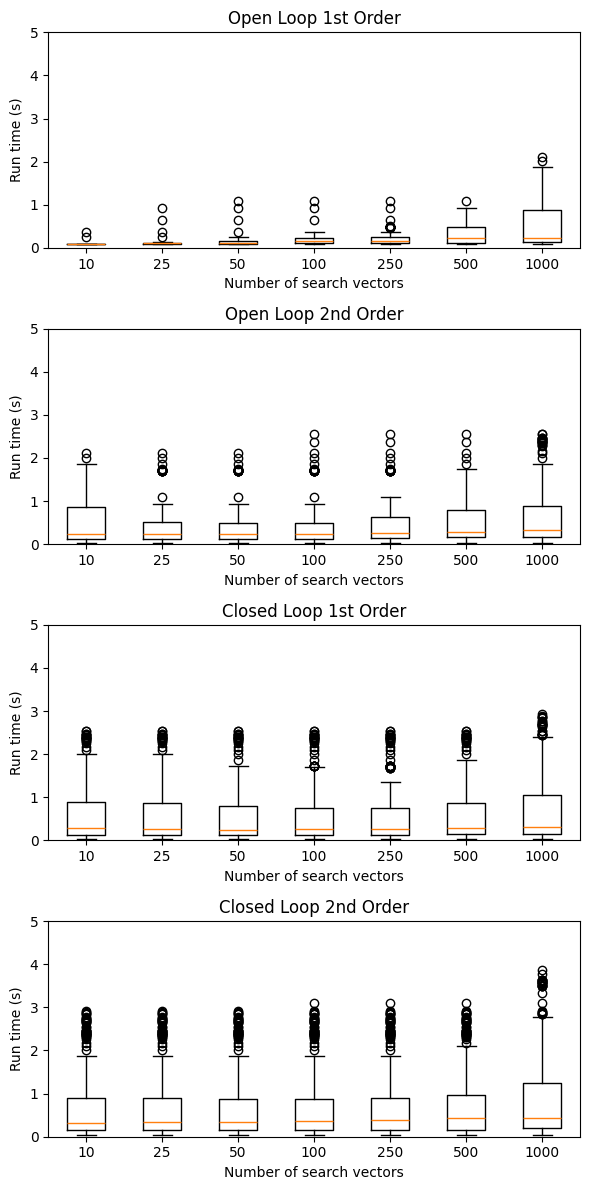

In [ ]:
# Plot results
# print(results_dict.keys())

# Create a figure with 4 rows and 1 column
plot_titles = ["Open Loop 1st Order", "Open Loop 2nd Order", "Closed Loop 1st Order", "Closed Loop 2nd Order"]
fig, axs = plt.subplots(4, 1, figsize=(6, 12))  # Adjust figsize as needed

# Plot something in each subplot
for i, ax in enumerate(axs):
    data = list(models_dict.values())[i]
    ax.boxplot(list(data.values()))
    ax.set_title(plot_titles[i])
    ax.set_xticklabels(test_n_vectors)
    ax.set_xlabel("Number of search vectors")
    ax.set_ylabel("Run time (s)")
    ax.set_ylim(np.array([0, 5]))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

# fig = plt.figure()
# ax = fig.add_axes([0, 0, 1, 1])
# bp = ax.boxplot(np.array(list(results_dict.values())) * 1000)

In [ ]:
# benchmark
import cProfile, pstats
profiler = cProfile.Profile()

n_vectors_test = [10, 25, 50, 100, 250, 500, 1000]
num_iters = 100

results = []
results_dict = {}



try:
    for n_vectors in n_vectors_test:
        print("Testing", n_vectors)
        profiler.enable()
        params_ls, ins, outs, boundaries, hull, expanded_hull = test_model(ol_1, n_vectors = n_vectors)
        profiler.disable()
        stats = pstats.Stats(profiler).sort_stats('cumtime')
        stats.print_stats()
except Exception as e: 
    print(e)
    profiler.disable()


Testing 10
         138259 function calls (137827 primitive calls) in 0.092 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.088    0.088 c:\Users\Jake\AppData\Local\Programs\Python\Python312\Lib\threading.py:637(wait)
        1    0.000    0.000    0.087    0.087 C:\Users\Jake\AppData\Local\Temp\ipykernel_9428\56440864.py:3(test_model)
        1    0.000    0.000    0.061    0.061 C:\Users\Jake\AppData\Local\Temp\ipykernel_9428\2218188320.py:1(get_lse)
        1    0.000    0.000    0.061    0.061 c:\Users\Jake\Learning-Dynamic-Systems\.venv\Lib\site-packages\scipy\optimize\_lsq\least_squares.py:241(least_squares)
        1    0.000    0.000    0.060    0.060 c:\Users\Jake\Learning-Dynamic-Systems\.venv\Lib\site-packages\scipy\optimize\_lsq\trf.py:112(trf)
        1    0.002    0.002    0.060    0.060 c:\Users\Jake\Learning-Dynamic-Systems\.venv\Lib\site-packages\scipy\optimize\_lsq\trf.py